In [1]:
from DCC import *
from Utils import *
from Plots import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from collections import defaultdict

In [2]:
init_plotting()

In [3]:
dataset2name = {
    "Bala_classification_dataset.csv": "Bala Classification",
    "Bala_regression_dataset.csv": "Bala Regression",
    "bandgap.csv": "Bandgap",
    "BMDS_data.csv": "BMDS",
    "Crystal_structure.csv": "Crystal Structure",
    "Glass.csv": "Glass",
    "PUE.csv": "PUE",
}

In [4]:
from enum import Enum
from sklearn.datasets import make_classification


class PerturbationType(Enum):
    Deletion = "Deletion"
    AdditionLinear = "AdditionLinear"
    AdditionRand = "AdditionRand"
    ReplacementLinear = "ReplacementLinear"
    ReplacementRand = "ReplacementRand"


def generate_random_according_df(
    n: int, m: int, df: pd.DataFrame, task_type=None, target_col=None
):
    cols = df.columns
    new_data = []
    for i in range(n):
        new_row = []
        for j in range(m):
            new_row.append(random.uniform(df[cols[j]].min(), df[cols[j]].max()))
        new_data.append(new_row)
    new_df = pd.DataFrame(new_data, columns=cols)
    if task_type == "classification":
        if target_col is not None:
            new_df[target_col] = np.random.choice(
                df[target_col].unique(), size=n, replace=True
            )
    return new_df


def generate_linear_according_df(
    n: int, m: int, df: pd.DataFrame, task_type=None, target_col=None
):
    if task_type == "classification":
        # Generate a classification dataset
        X, y = make_classification(
            n_samples=n,
            n_features=m - 1,
            n_classes=len(df[target_col].unique()),
            n_informative= (m - 1) // 2,
        )[:2]
    else:
        X, y = make_regression(
            n_samples=n, n_features=m - 1, noise=0.1
        )[:2]

    X_cols = [x for x in df.columns if x != target_col]
    df_linear = pd.DataFrame(X, columns=X_cols)
    df_linear[target_col] = y
    # normalize the data to the range of df
    for col in df.columns:
        min_val = df[col].min()
        max_val = df[col].max()
        df_linear[col] = (df_linear[col] - df_linear[col].min()) / (
            df_linear[col].max() - df_linear[col].min()
        ) * (max_val - min_val) + min_val

    return df_linear


def dcc_exp(
    data: pd.DataFrame,
    ptb_type: PerturbationType,
    task_type,
    target_col,
    ratio=0.1,
    eps=0.04,
    corr_func=dcor_matrix,
):
    eps /= 2
    n, m = data.shape
    if ptb_type == PerturbationType.Deletion:
        perturbed_data = data.sample(frac=1 - ratio)
    elif ptb_type == PerturbationType.AdditionLinear:
        df_linear = generate_linear_according_df(
            n // 20, m, data, task_type, target_col
        )
        perturbed_data = pd.concat([data, df_linear], ignore_index=True)
    elif ptb_type == PerturbationType.AdditionRand:
        df_rand = generate_random_according_df(n // 20, m, data, task_type, target_col)
        perturbed_data = pd.concat([data, df_rand], ignore_index=True)
    elif ptb_type == PerturbationType.ReplacementLinear:
        df_linear = generate_linear_according_df(
            n // 20, m, data, task_type, target_col
        )
        perturbed_data = random_replace_rows(data, df_linear)
    elif ptb_type == PerturbationType.ReplacementRand:
        df_rand = generate_random_according_df(n // 20, m, data, task_type, target_col)
        perturbed_data = random_replace_rows(data, df_rand)
    else:
        raise ValueError(f"Unknown perturbation type: {ptb_type}")

    return dcc_diff_features(data, perturbed_data, target_col, eps=eps, corr_func=corr_func), perturbed_data

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from joblib import Parallel, delayed
import shap

dataset_dir = Path("processed_data")
datasets = list(dataset_dir.glob("*.csv"))
dataset_config = {
    "Bala_classification_dataset.csv": {
        "target_col": "Formability",
        "type": "classification",
    },
    "Bala_regression_dataset.csv": {
        "target_col": "Ferroelectric_Tc_in_Kelvin",
        "type": "regression",
    },
    "bandgap.csv": {
        "target_col": "target",
        "type": "regression",
    },
    "BMDS_data.csv": {
        "target_col": "soc_bandgap",
        "type": "regression",
    },
    "Crystal_structure.csv": {
        "target_col": "Lowest distortion",
        "type": "classification",
    },
    "Glass.csv": {
        "target_col": "Type of glass",
        "type": "classification",
    },
    "PUE.csv": {
        "target_col": "logYM",
        "type": "regression",
    },
}
def get_shap_values(df, target_col, type):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    if type == "regression":
        model = RandomForestRegressor(n_estimators=500, random_state=42)
    elif type == "classification":
        model = RandomForestClassifier(n_estimators=500, random_state=42)
    else:
        raise ValueError("type must be either 'regression' or 'classification'")
    model.fit(X, y)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    # shap.summary_plot(shap_values, X, plot_type="bar")
    if type == "classification":
        # For classification, shap_values is a list of arrays, one for each class
        # We take the mean absolute value across all classes
        mean_abs_shap = np.mean(np.mean(np.abs(shap_values), axis=0), axis=1)
    else:
        mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    # print(f"Mean absolute SHAP values: {mean_abs_shap}")
    feats2shap = {col: mean_abs_shap[i] for i, col in enumerate(X.columns)}
    return feats2shap


In [6]:
results = defaultdict(dict)

dataset_dir = Path("processed_data")
for d in dataset_dir.glob("*.csv"):
    print(d.name)
    df = pd.read_csv(d)
    target_col = dataset_config[d.name]["target_col"]
    task_type = dataset_config[d.name]["type"]
    feats2shap = get_shap_values(df, target_col, task_type)
    results[d.name]["ori_feats2shap"] = feats2shap
    results[d.name]["name"] = dataset2name[d.name]
    results[d.name]["type"] = task_type
    results[d.name]["target_col"] = target_col

    results[d.name][PerturbationType.Deletion.value] = {}
    results[d.name][PerturbationType.AdditionLinear.value] = {}
    results[d.name][PerturbationType.AdditionRand.value] = {}
    results[d.name][PerturbationType.ReplacementLinear.value] = {}
    results[d.name][PerturbationType.ReplacementRand.value] = {}


    for ptb_type in PerturbationType:
        print(f"Perturbation type: {ptb_type.value}")
        dcc_val, perturbed_df = dcc_exp(df, ptb_type,task_type, target_col,ratio=0.1, eps=0.04)
        feats2shap = get_shap_values(perturbed_df, target_col, task_type)
        results[d.name][ptb_type.value]["dcc"] = dcc_val
        results[d.name][ptb_type.value]["feats2shap"] = feats2shap

Bala_classification_dataset.csv
Perturbation type: Deletion
Perturbation type: AdditionLinear
Perturbation type: AdditionRand
Perturbation type: ReplacementLinear
Perturbation type: ReplacementRand
Bala_regression_dataset.csv
Perturbation type: Deletion
Perturbation type: AdditionLinear
Perturbation type: AdditionRand
Perturbation type: ReplacementLinear
Perturbation type: ReplacementRand
bandgap.csv
Perturbation type: Deletion


d:\software\miniforge3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Perturbation type: AdditionLinear
Perturbation type: AdditionRand
Perturbation type: ReplacementLinear


d:\software\miniforge3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Perturbation type: ReplacementRand
BMDS_data.csv
Perturbation type: Deletion
Perturbation type: AdditionLinear
Perturbation type: AdditionRand
Perturbation type: ReplacementLinear
Perturbation type: ReplacementRand
Crystal_structure.csv
Perturbation type: Deletion
Perturbation type: AdditionLinear
Perturbation type: AdditionRand
Perturbation type: ReplacementLinear
Perturbation type: ReplacementRand
Glass.csv
Perturbation type: Deletion
Perturbation type: AdditionLinear
Perturbation type: AdditionRand
Perturbation type: ReplacementLinear
Perturbation type: ReplacementRand
PUE.csv
Perturbation type: Deletion
Perturbation type: AdditionLinear
Perturbation type: AdditionRand
Perturbation type: ReplacementLinear
Perturbation type: ReplacementRand


In [7]:
results

defaultdict(dict,
            {'Bala_classification_dataset.csv': {'ori_feats2shap': {'Compound': 0.03134094185329982,
               'x(BiMe1Me2)O3': 0.03253681248549997,
               'Me1': 0.03877389122758503,
               'Me2': 0.03135248369332674,
               'frac-Me1': 0.010455383934140304,
               'frac-Me2': 0.012826707669024998,
               'frac-Me3': 0.0014052899024165804,
               'PT-content': 0.03145345210691547,
               'Tolerance_Factor': 0.057509877941759366,
               'Valence_Electron_Number': 0.022618344283104205,
               'Martynov_Batsanov_Electronegativity': 0.05540413959655249,
               'Ideal_Bond_Length_Sum': 0.03186445153895874,
               'Mendeleev_Number': 0.0964075149296759},
              'name': 'Bala Classification',
              'type': 'classification',
              'target_col': 'Formability',
              'Deletion': {'dcc': {'Compound': 0.9285714285714286,
                'x(BiMe1Me2)O3': 0.8

In [8]:
# save to pickle file

import pickle

with open("results/dcc_fi_results-dcor.pkl", "wb") as f:
    pickle.dump(results, f)

In [9]:
# read from pickle file
import pickle

results = {}

with open("results/dcc_fi_results-dcor.pkl", "rb") as f:
    results = pickle.load(f)

results

defaultdict(dict,
            {'Bala_classification_dataset.csv': {'ori_feats2shap': {'Compound': 0.03134094185329982,
               'x(BiMe1Me2)O3': 0.03253681248549997,
               'Me1': 0.03877389122758503,
               'Me2': 0.03135248369332674,
               'frac-Me1': 0.010455383934140304,
               'frac-Me2': 0.012826707669024998,
               'frac-Me3': 0.0014052899024165804,
               'PT-content': 0.03145345210691547,
               'Tolerance_Factor': 0.057509877941759366,
               'Valence_Electron_Number': 0.022618344283104205,
               'Martynov_Batsanov_Electronegativity': 0.05540413959655249,
               'Ideal_Bond_Length_Sum': 0.03186445153895874,
               'Mendeleev_Number': 0.0964075149296759},
              'name': 'Bala Classification',
              'type': 'classification',
              'target_col': 'Formability',
              'Deletion': {'dcc': {'Compound': 0.9285714285714286,
                'x(BiMe1Me2)O3': 0.8

In [10]:
from enum import Enum

class PerturbationType(Enum):
    Deletion = "Deletion"
    AdditionLinear = "AdditionLinear"
    AdditionRand = "AdditionRand"
    ReplacementLinear = "ReplacementLinear"
    ReplacementRand = "ReplacementRand"

In [11]:
results.keys()

dict_keys(['Bala_classification_dataset.csv', 'Bala_regression_dataset.csv', 'bandgap.csv', 'BMDS_data.csv', 'Crystal_structure.csv', 'Glass.csv', 'PUE.csv'])

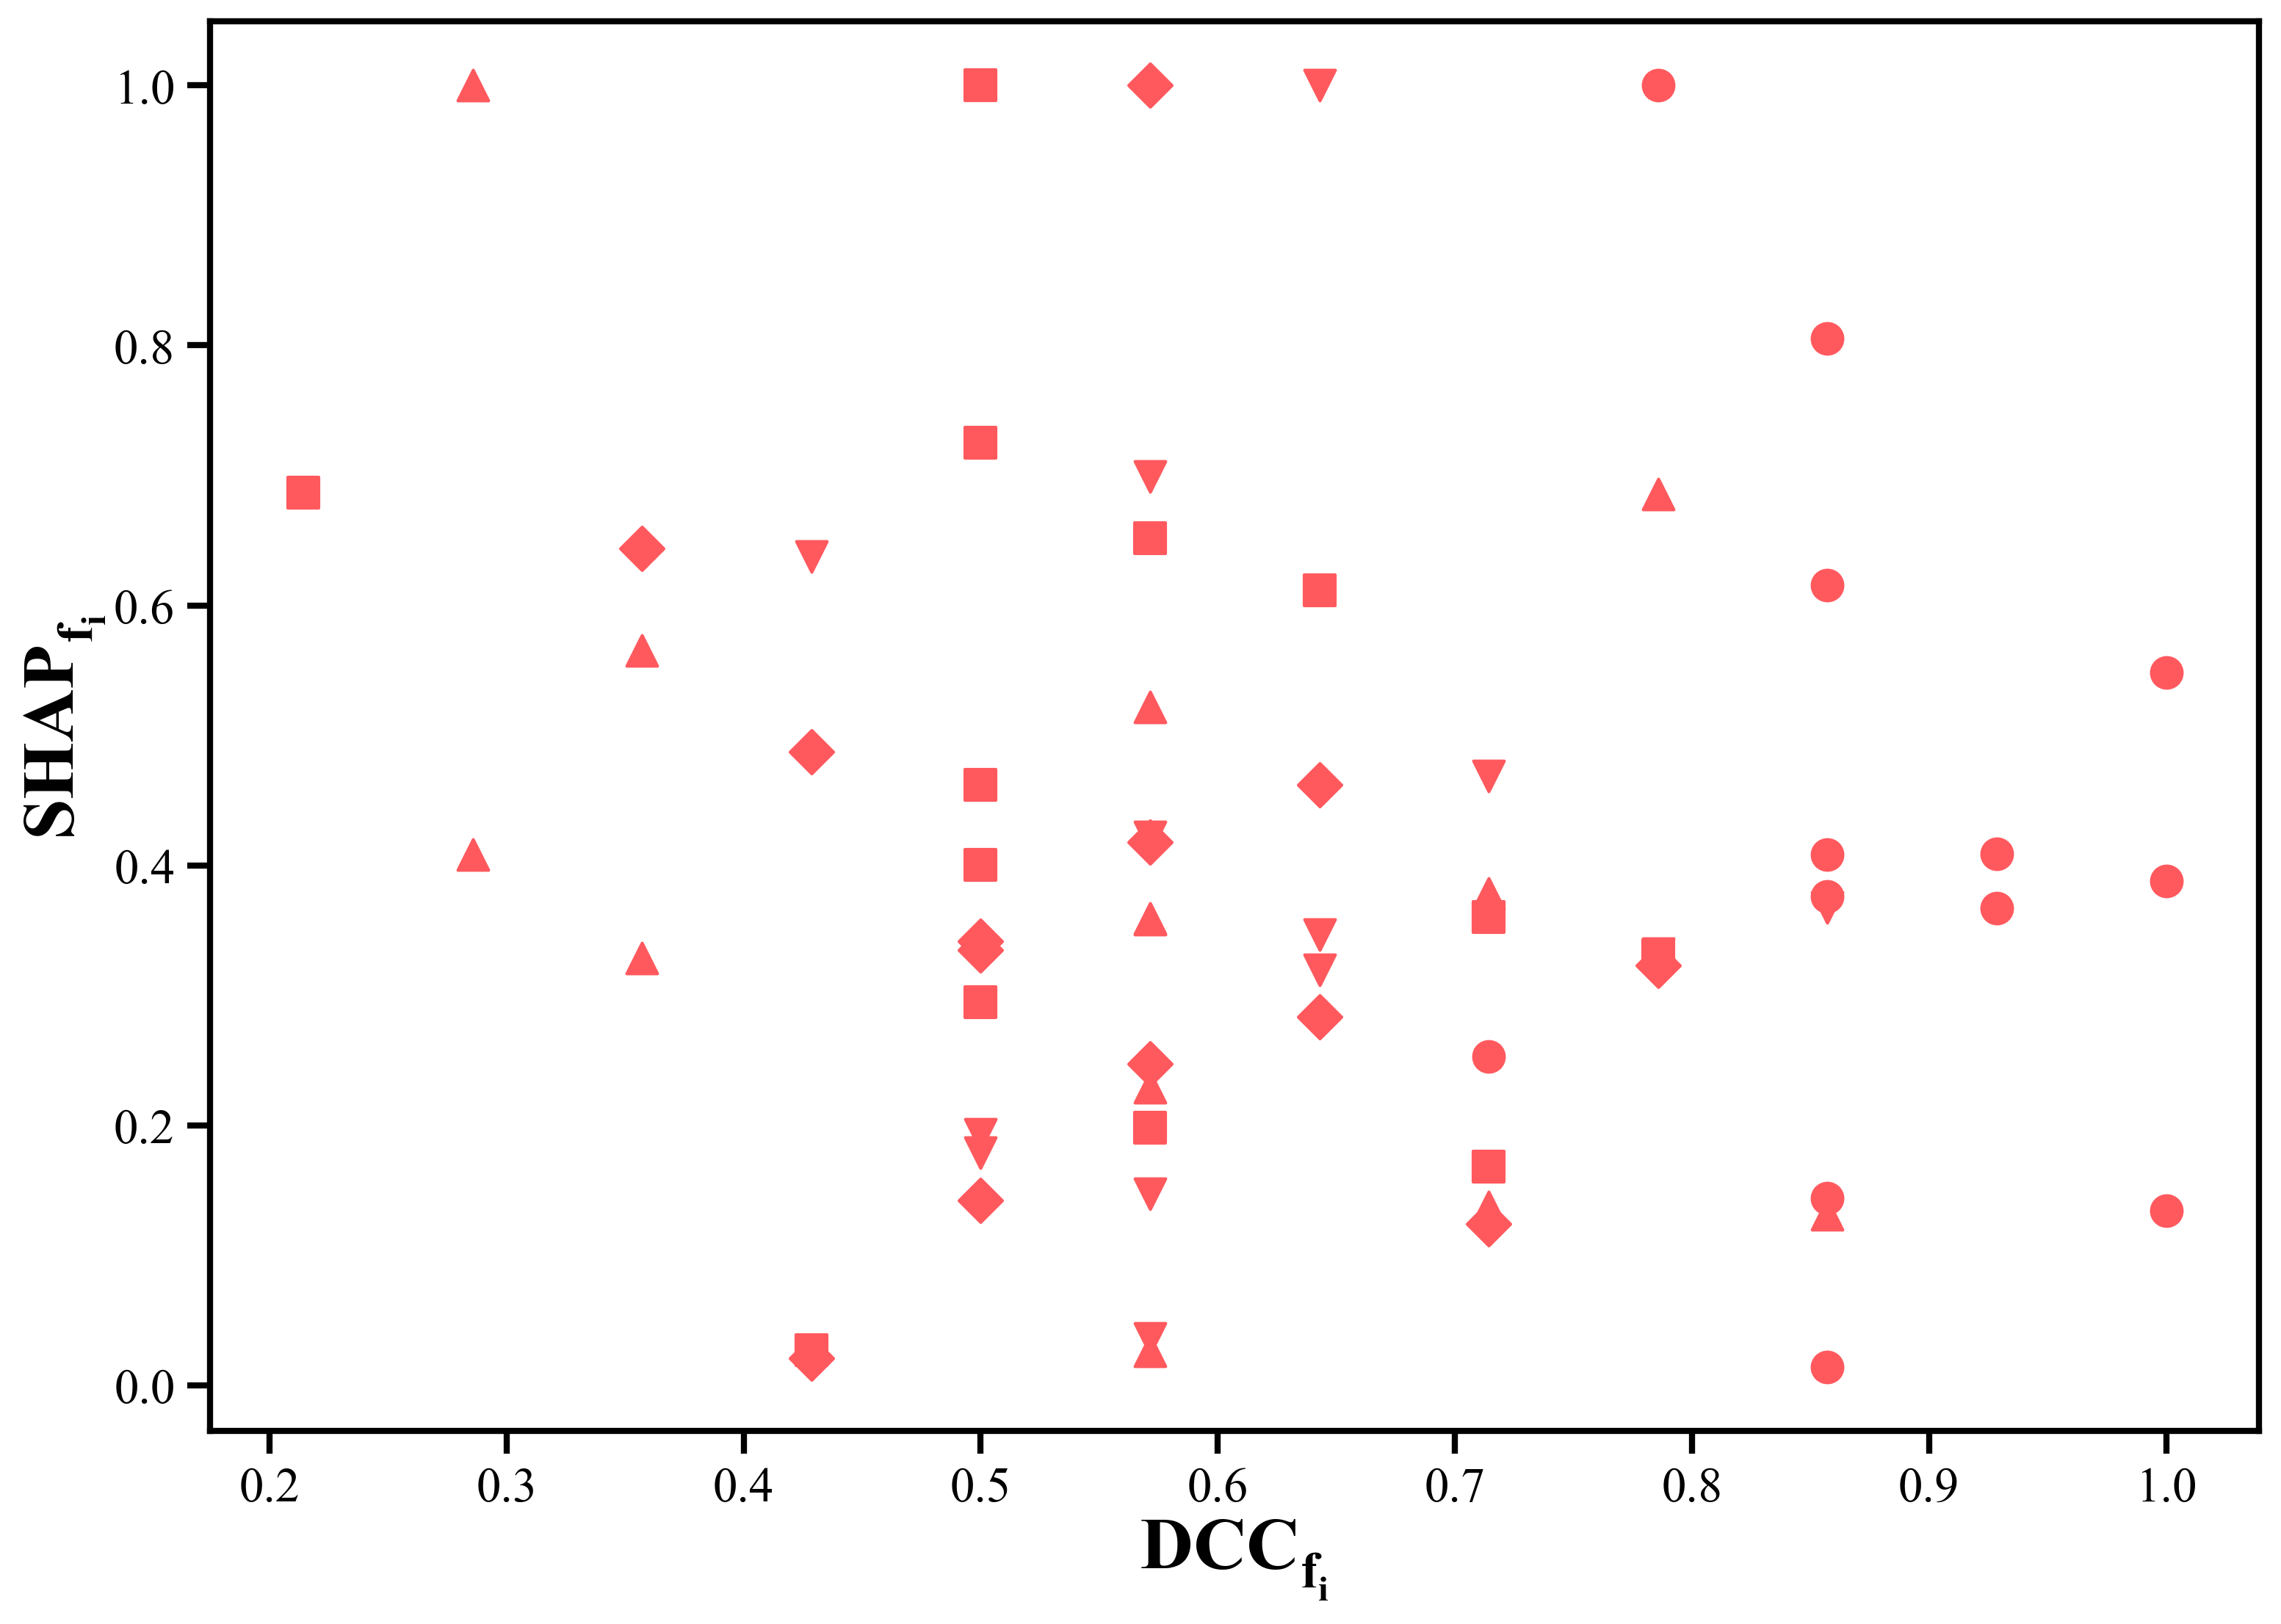

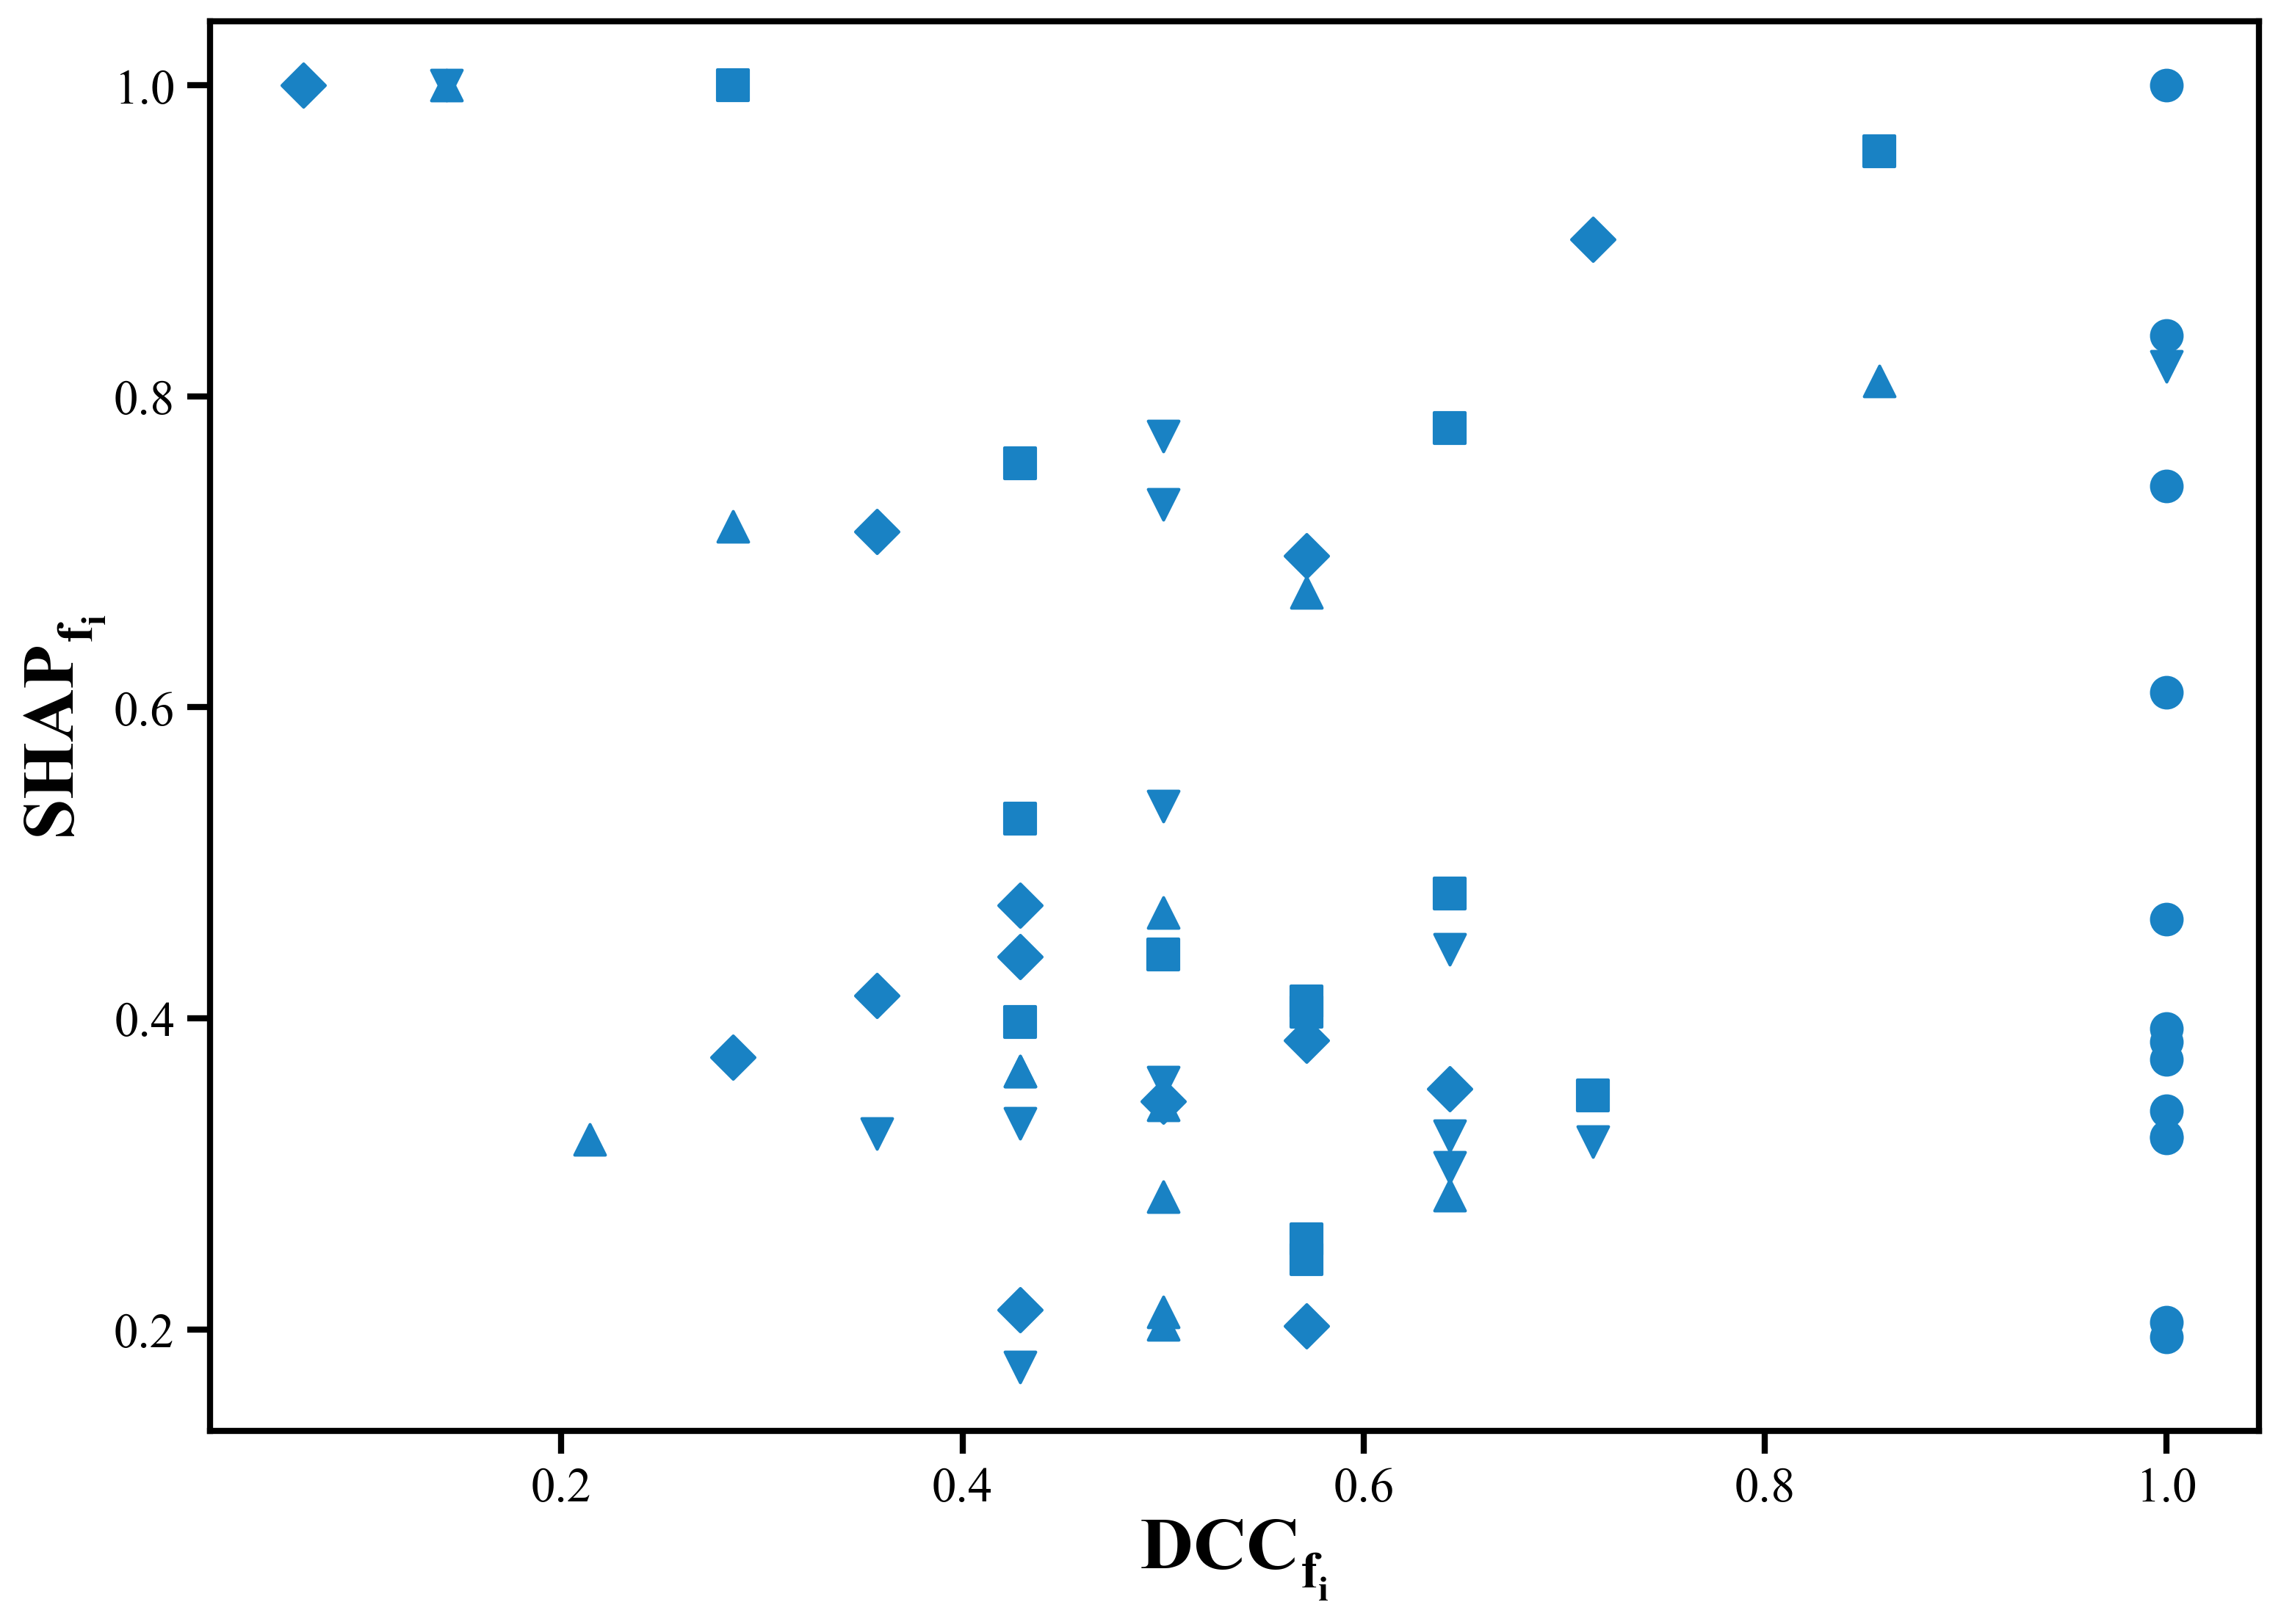

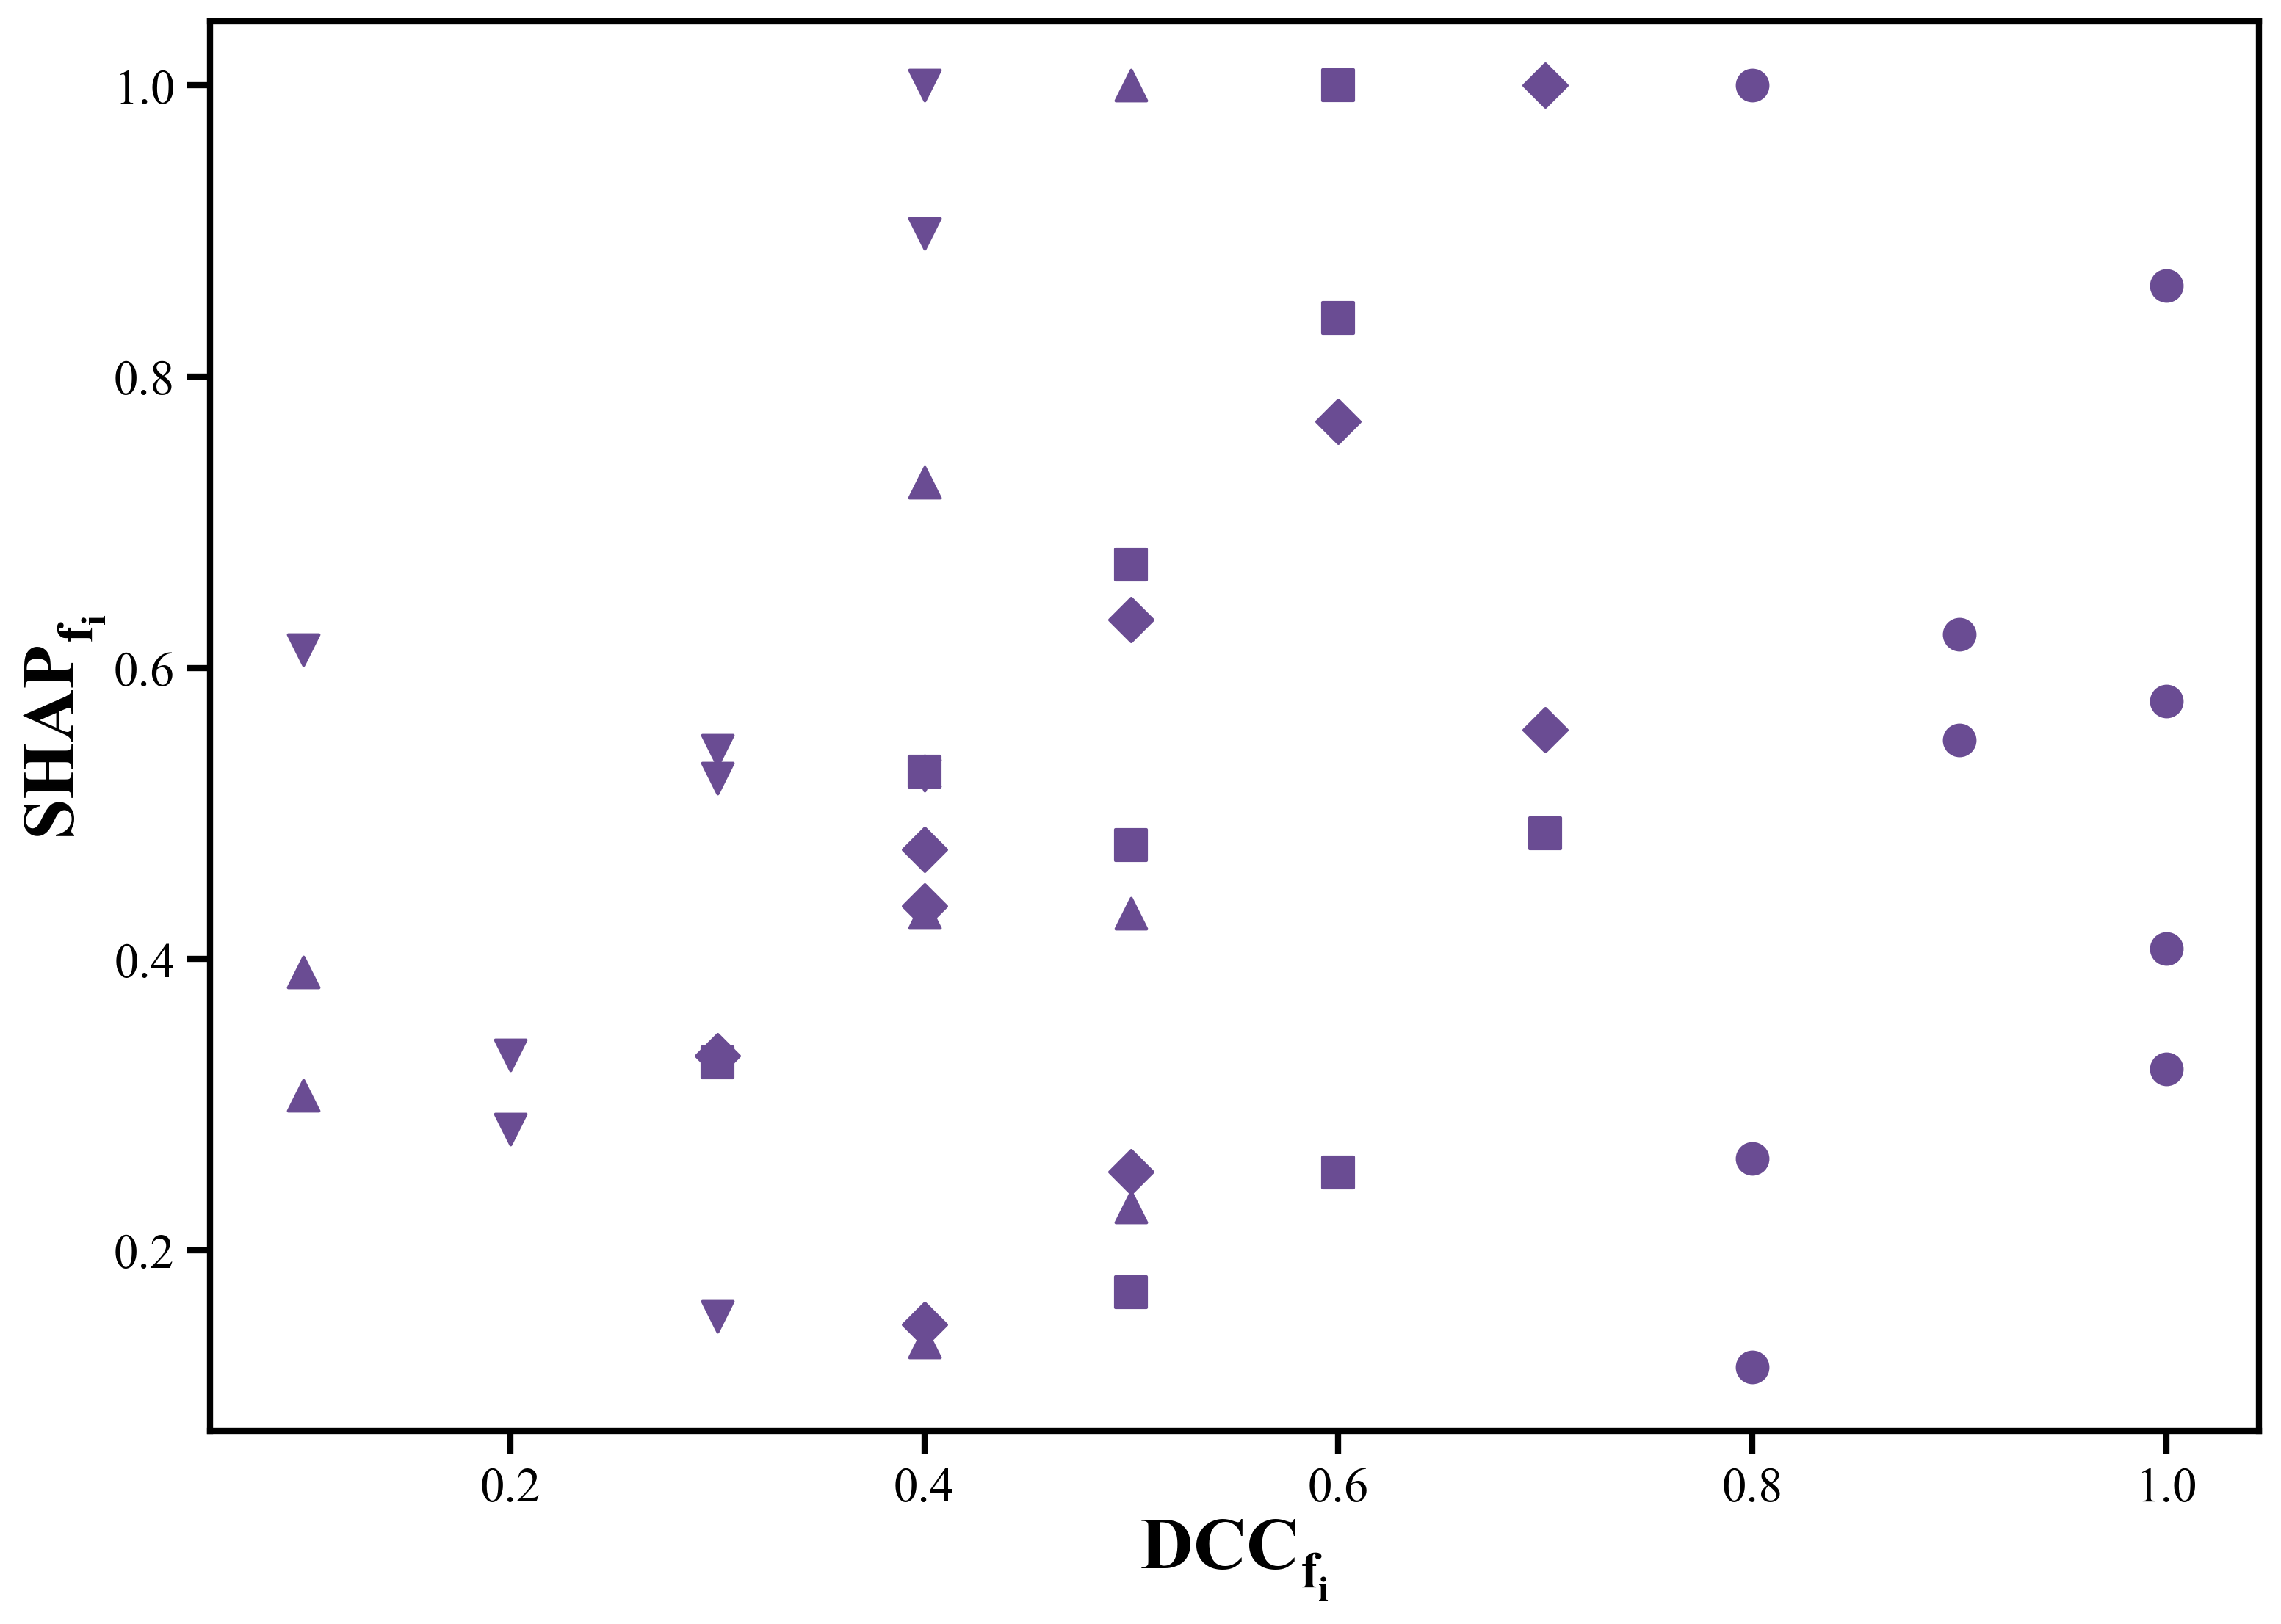

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D



markers = ["o", "s", "D", "v", "^"]
labels = [
    "Deletion",
    r"$Addition_{Linear}$",
    r"$Addition_{Random}$",
    r"$Replacement_{Linear}$",
    r"$Replacement_{Random}$",
]
dataset2colors = {}
colors = ["#ff595e","#1982c4","#6a4c93","#d677b8", "#222222"]
for k in results.keys():
    
    dataset_name = results[k]["name"]
    task_type = results[k]["type"]
    target_col = results[k]["target_col"]
    if task_type == "classification":
        fig, ax = plt.subplots(figsize=(12, 8))
        color = colors.pop(0)
        dataset2colors[dataset_name] = color
        for ptb_type in PerturbationType:
            if ptb_type.value not in results[k]:
                continue
            dcc_val = results[k][ptb_type.value]["dcc"]
            feats2shap = results[k][ptb_type.value]["feats2shap"]
            feats = list(feats2shap.keys())
            shape_values = [feats2shap[f] for f in feats]
            shape_values = np.array(shape_values)
            shape_values = shape_values / np.max(shape_values)  # Normalize to [0, 1]
            dcc_values = [dcc_val[f] for f in feats]
            plt.scatter(
                dcc_values,
                shape_values,
                marker=markers[list(PerturbationType).index(ptb_type)],
                s=100,
                color=color,
                label=f"{dataset_name}",
            )
        plt.xlabel(r"$DCC_{f_i}$")
        plt.ylabel(r"$SHAP_{f_i}$")

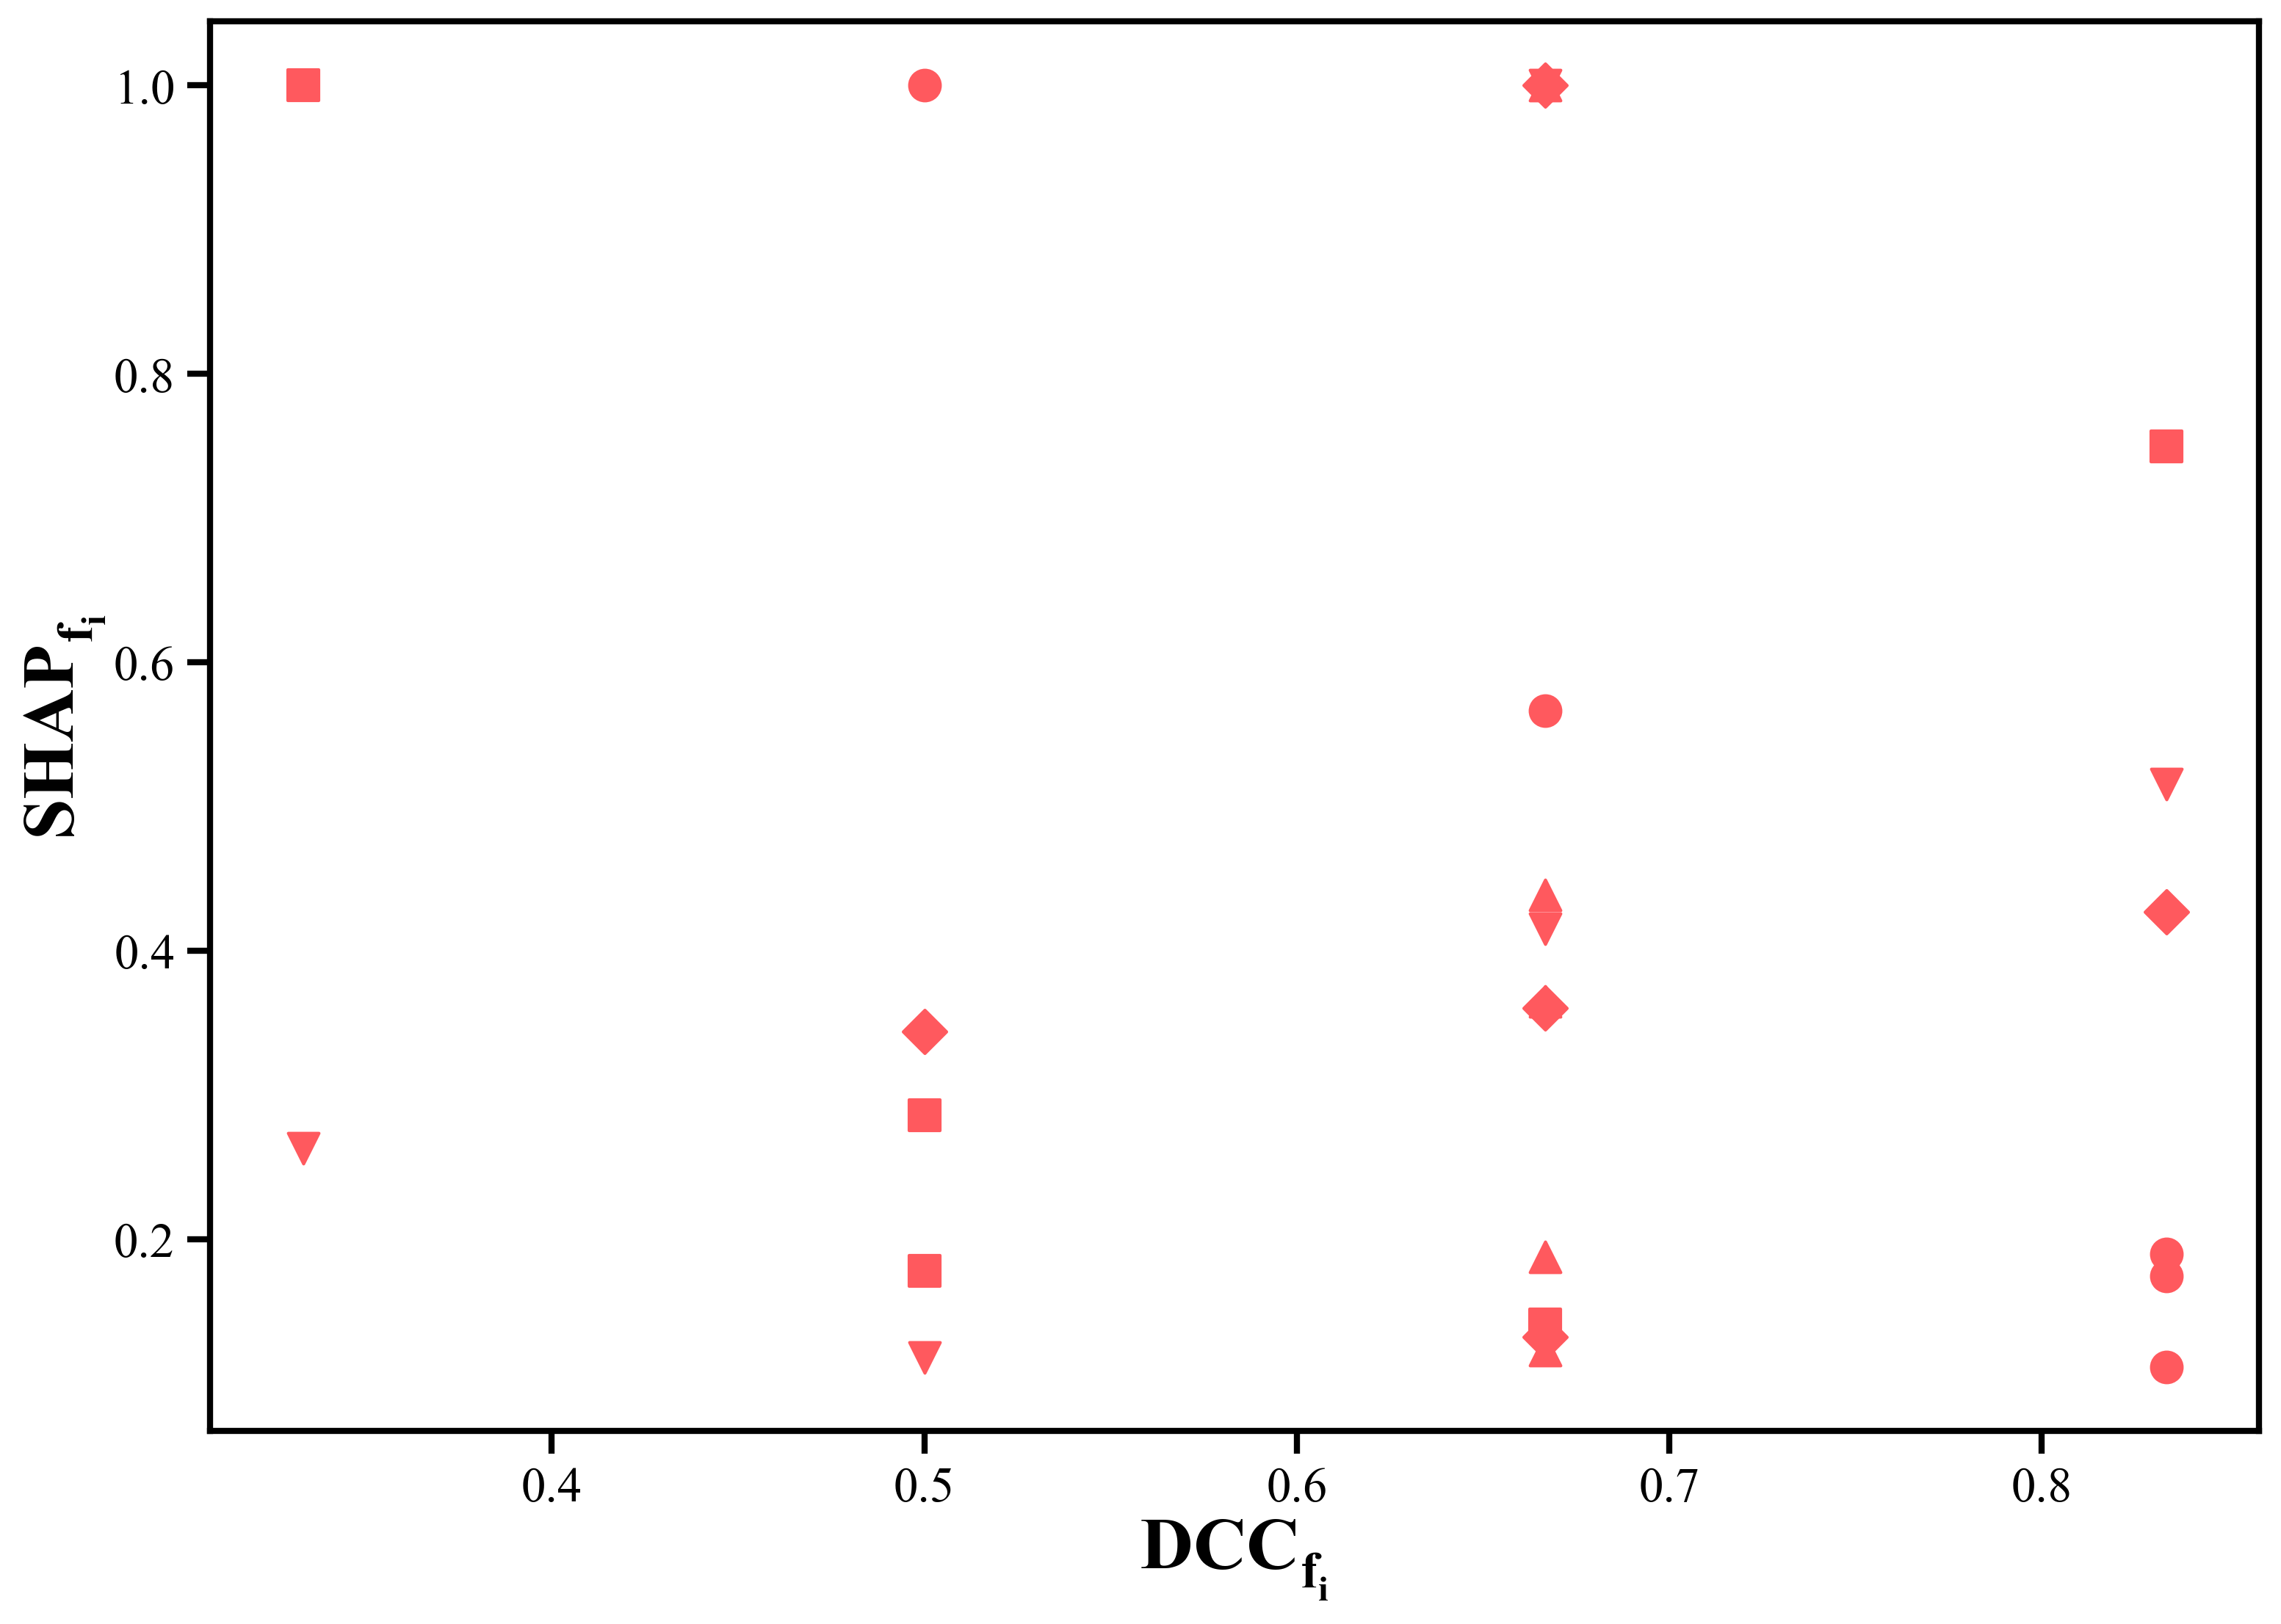

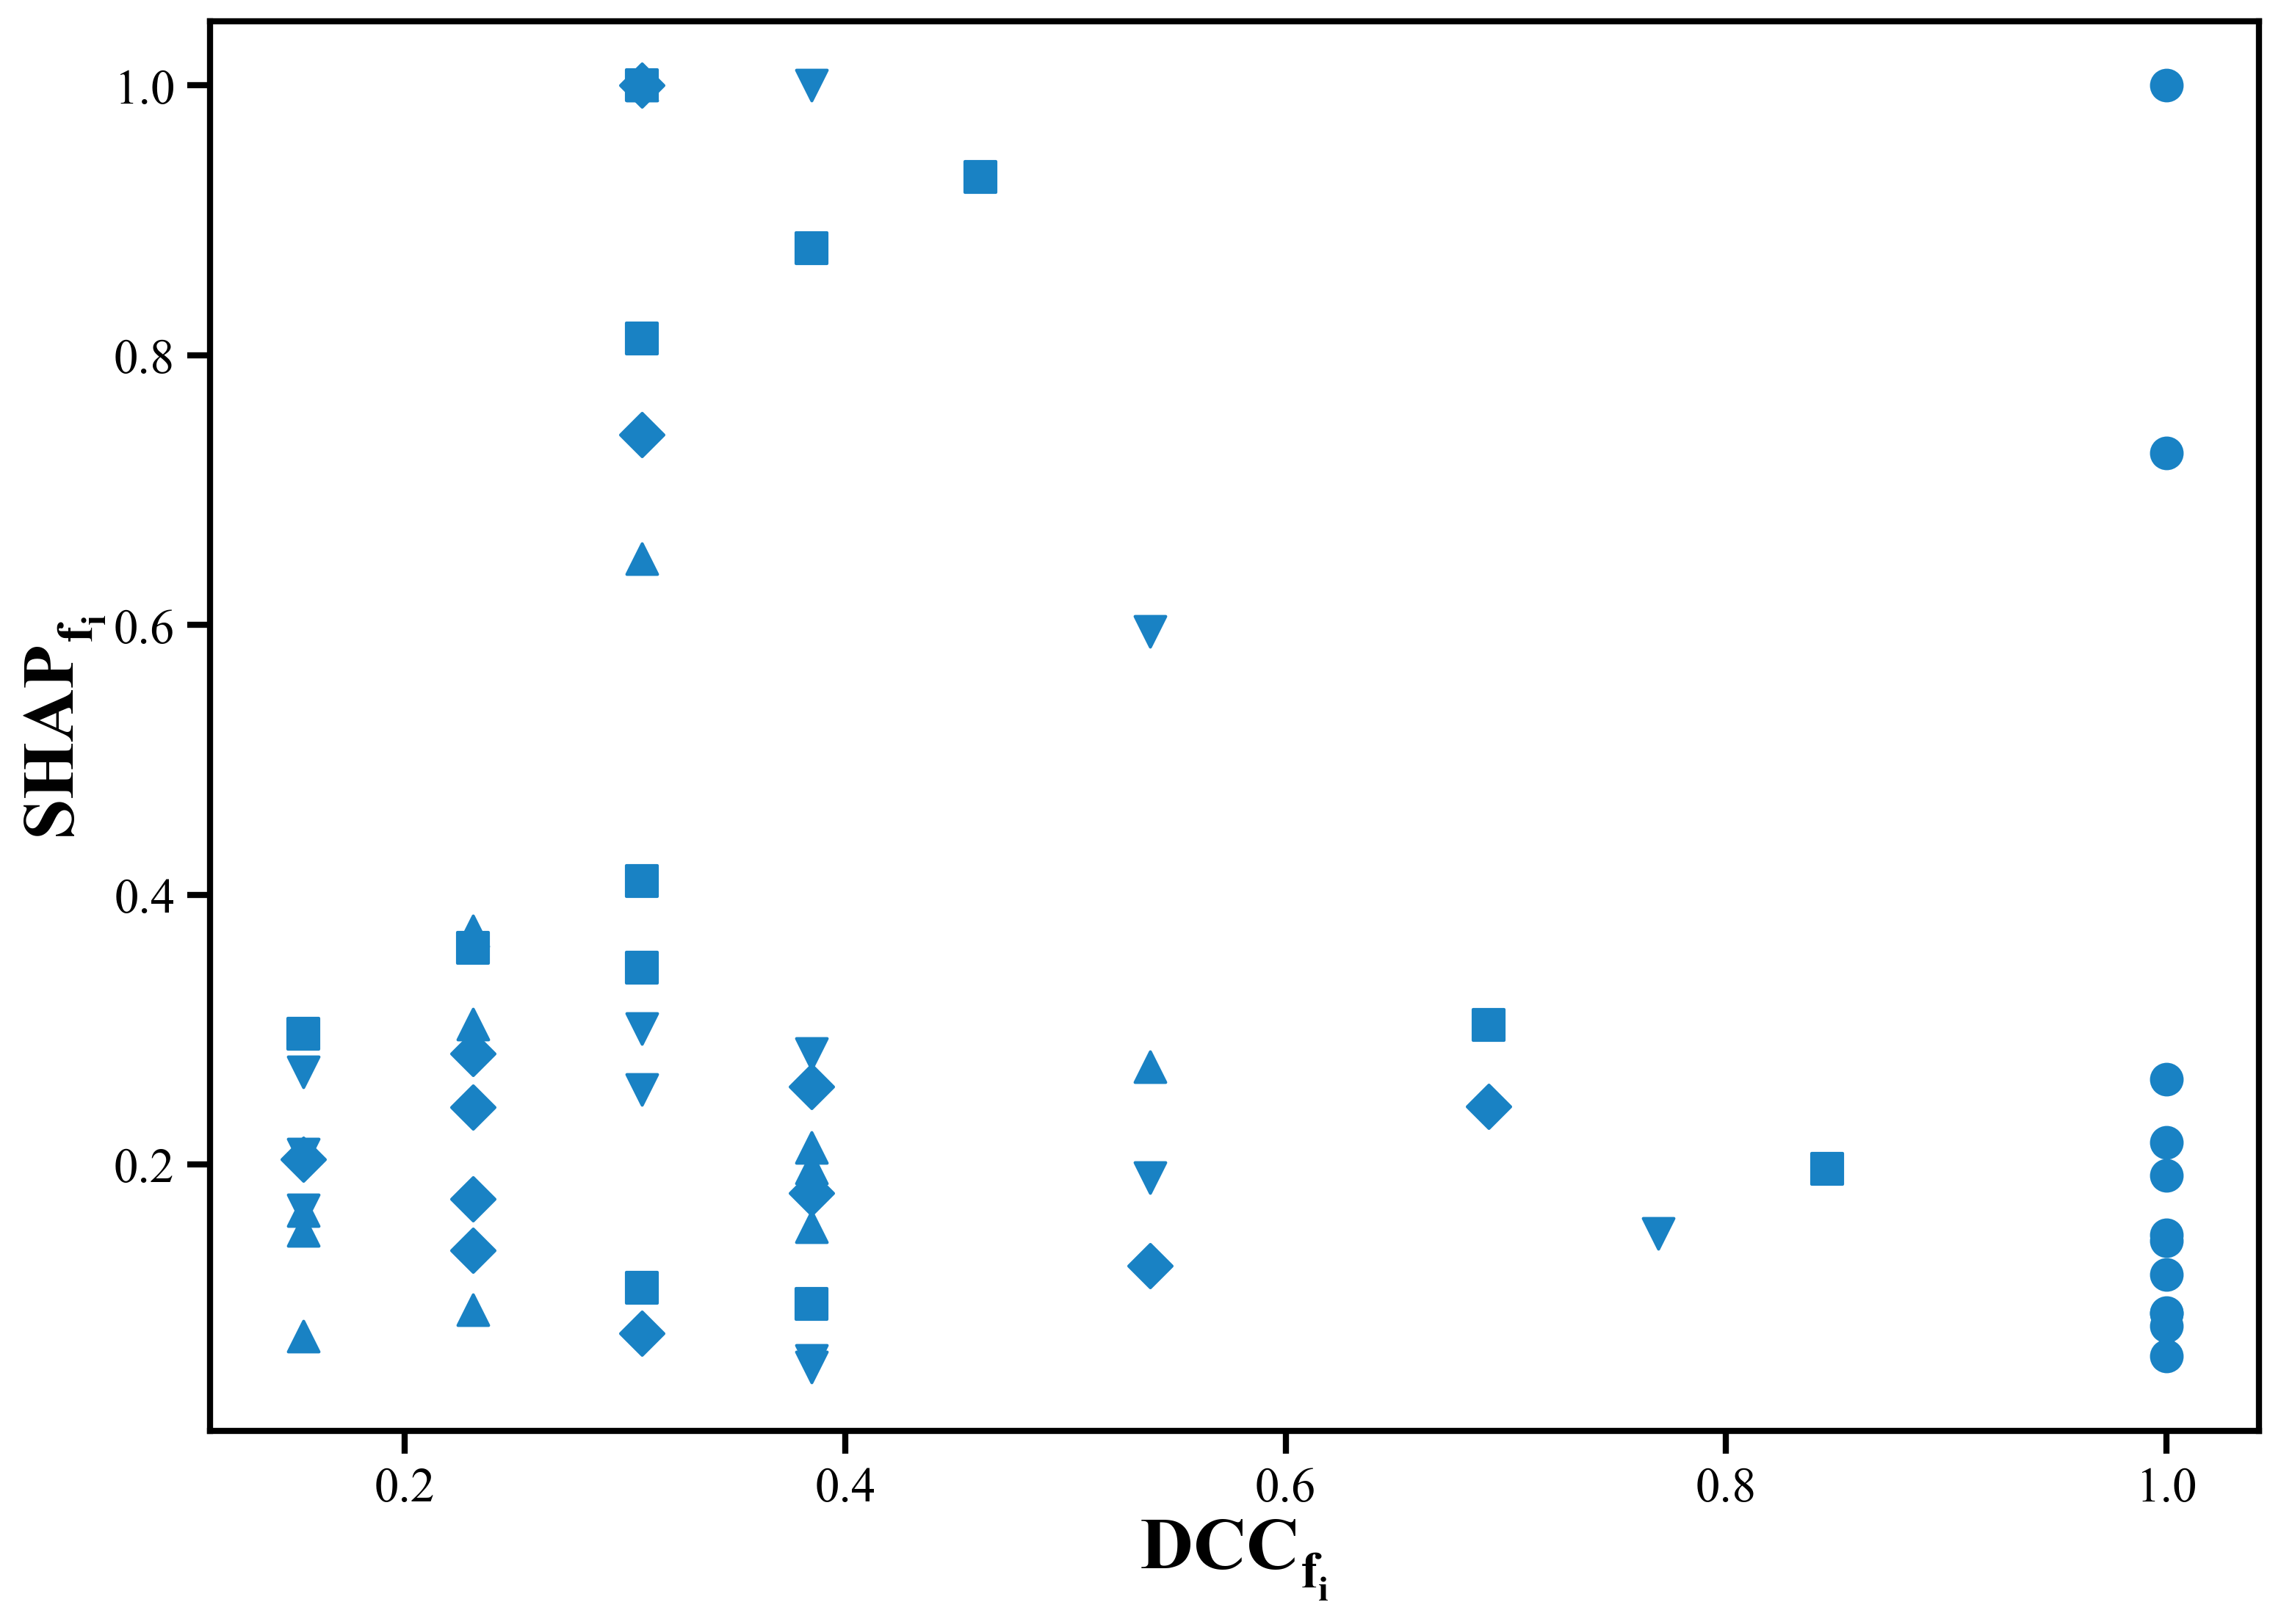

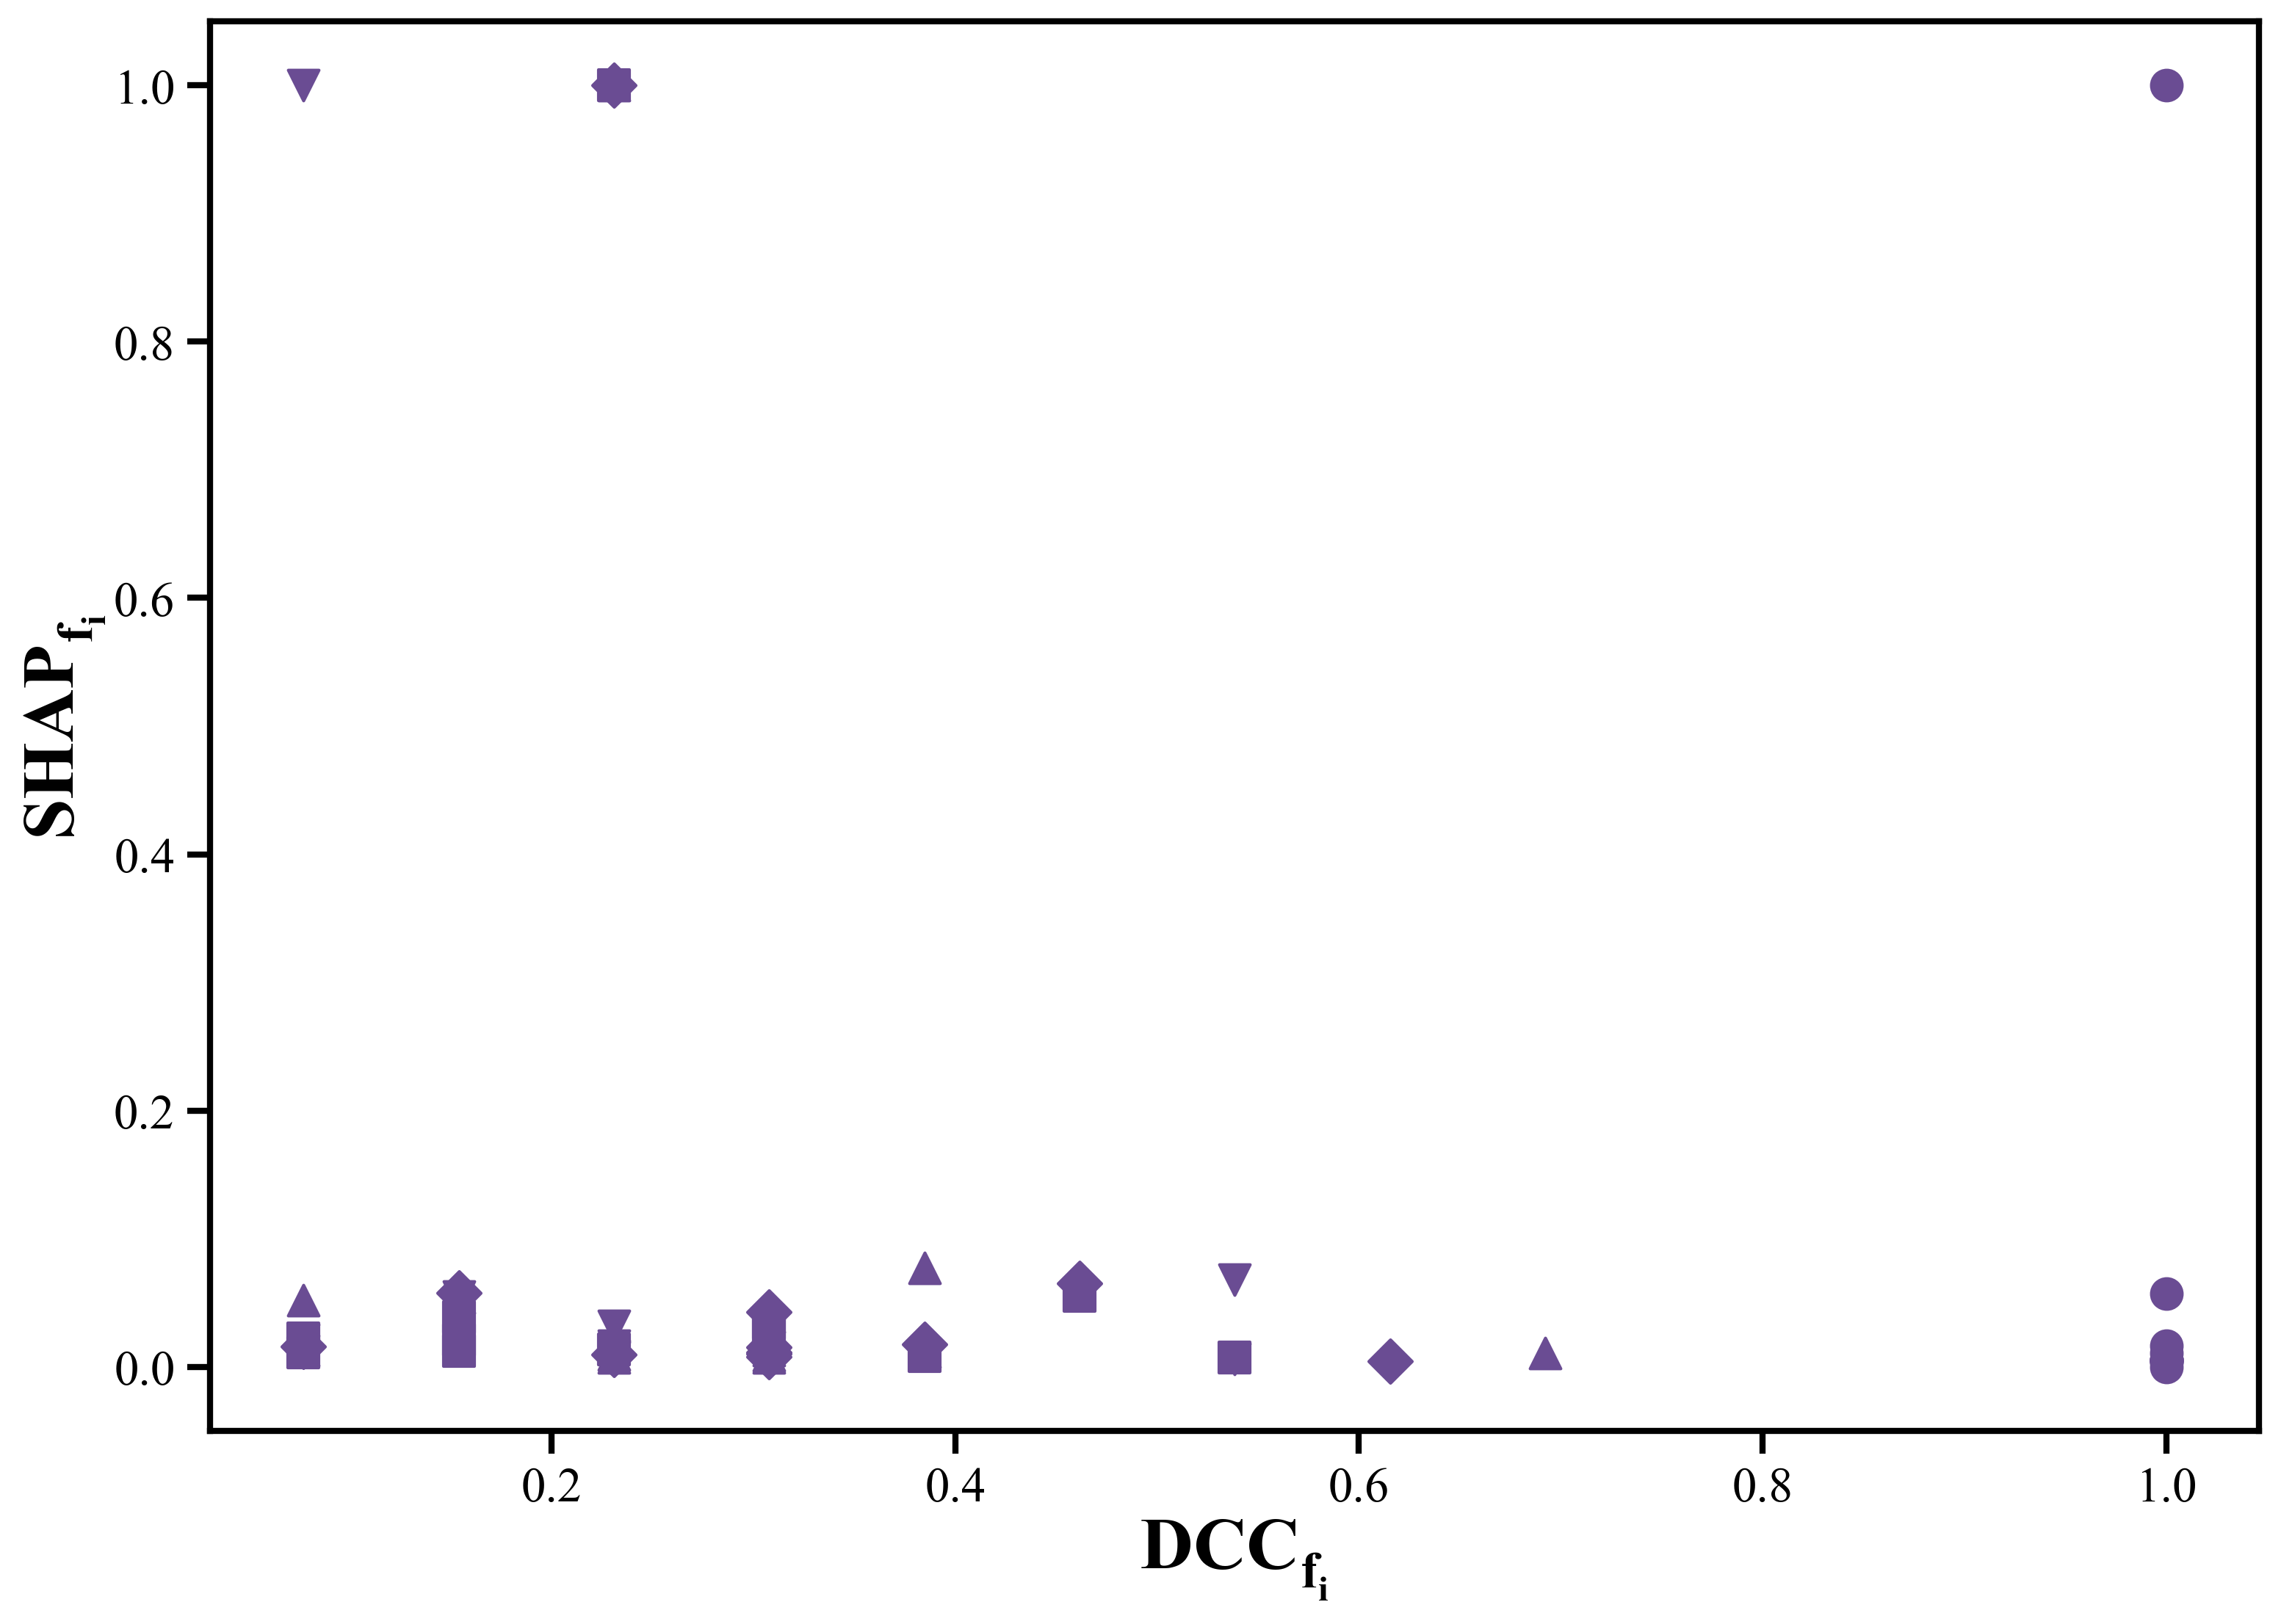

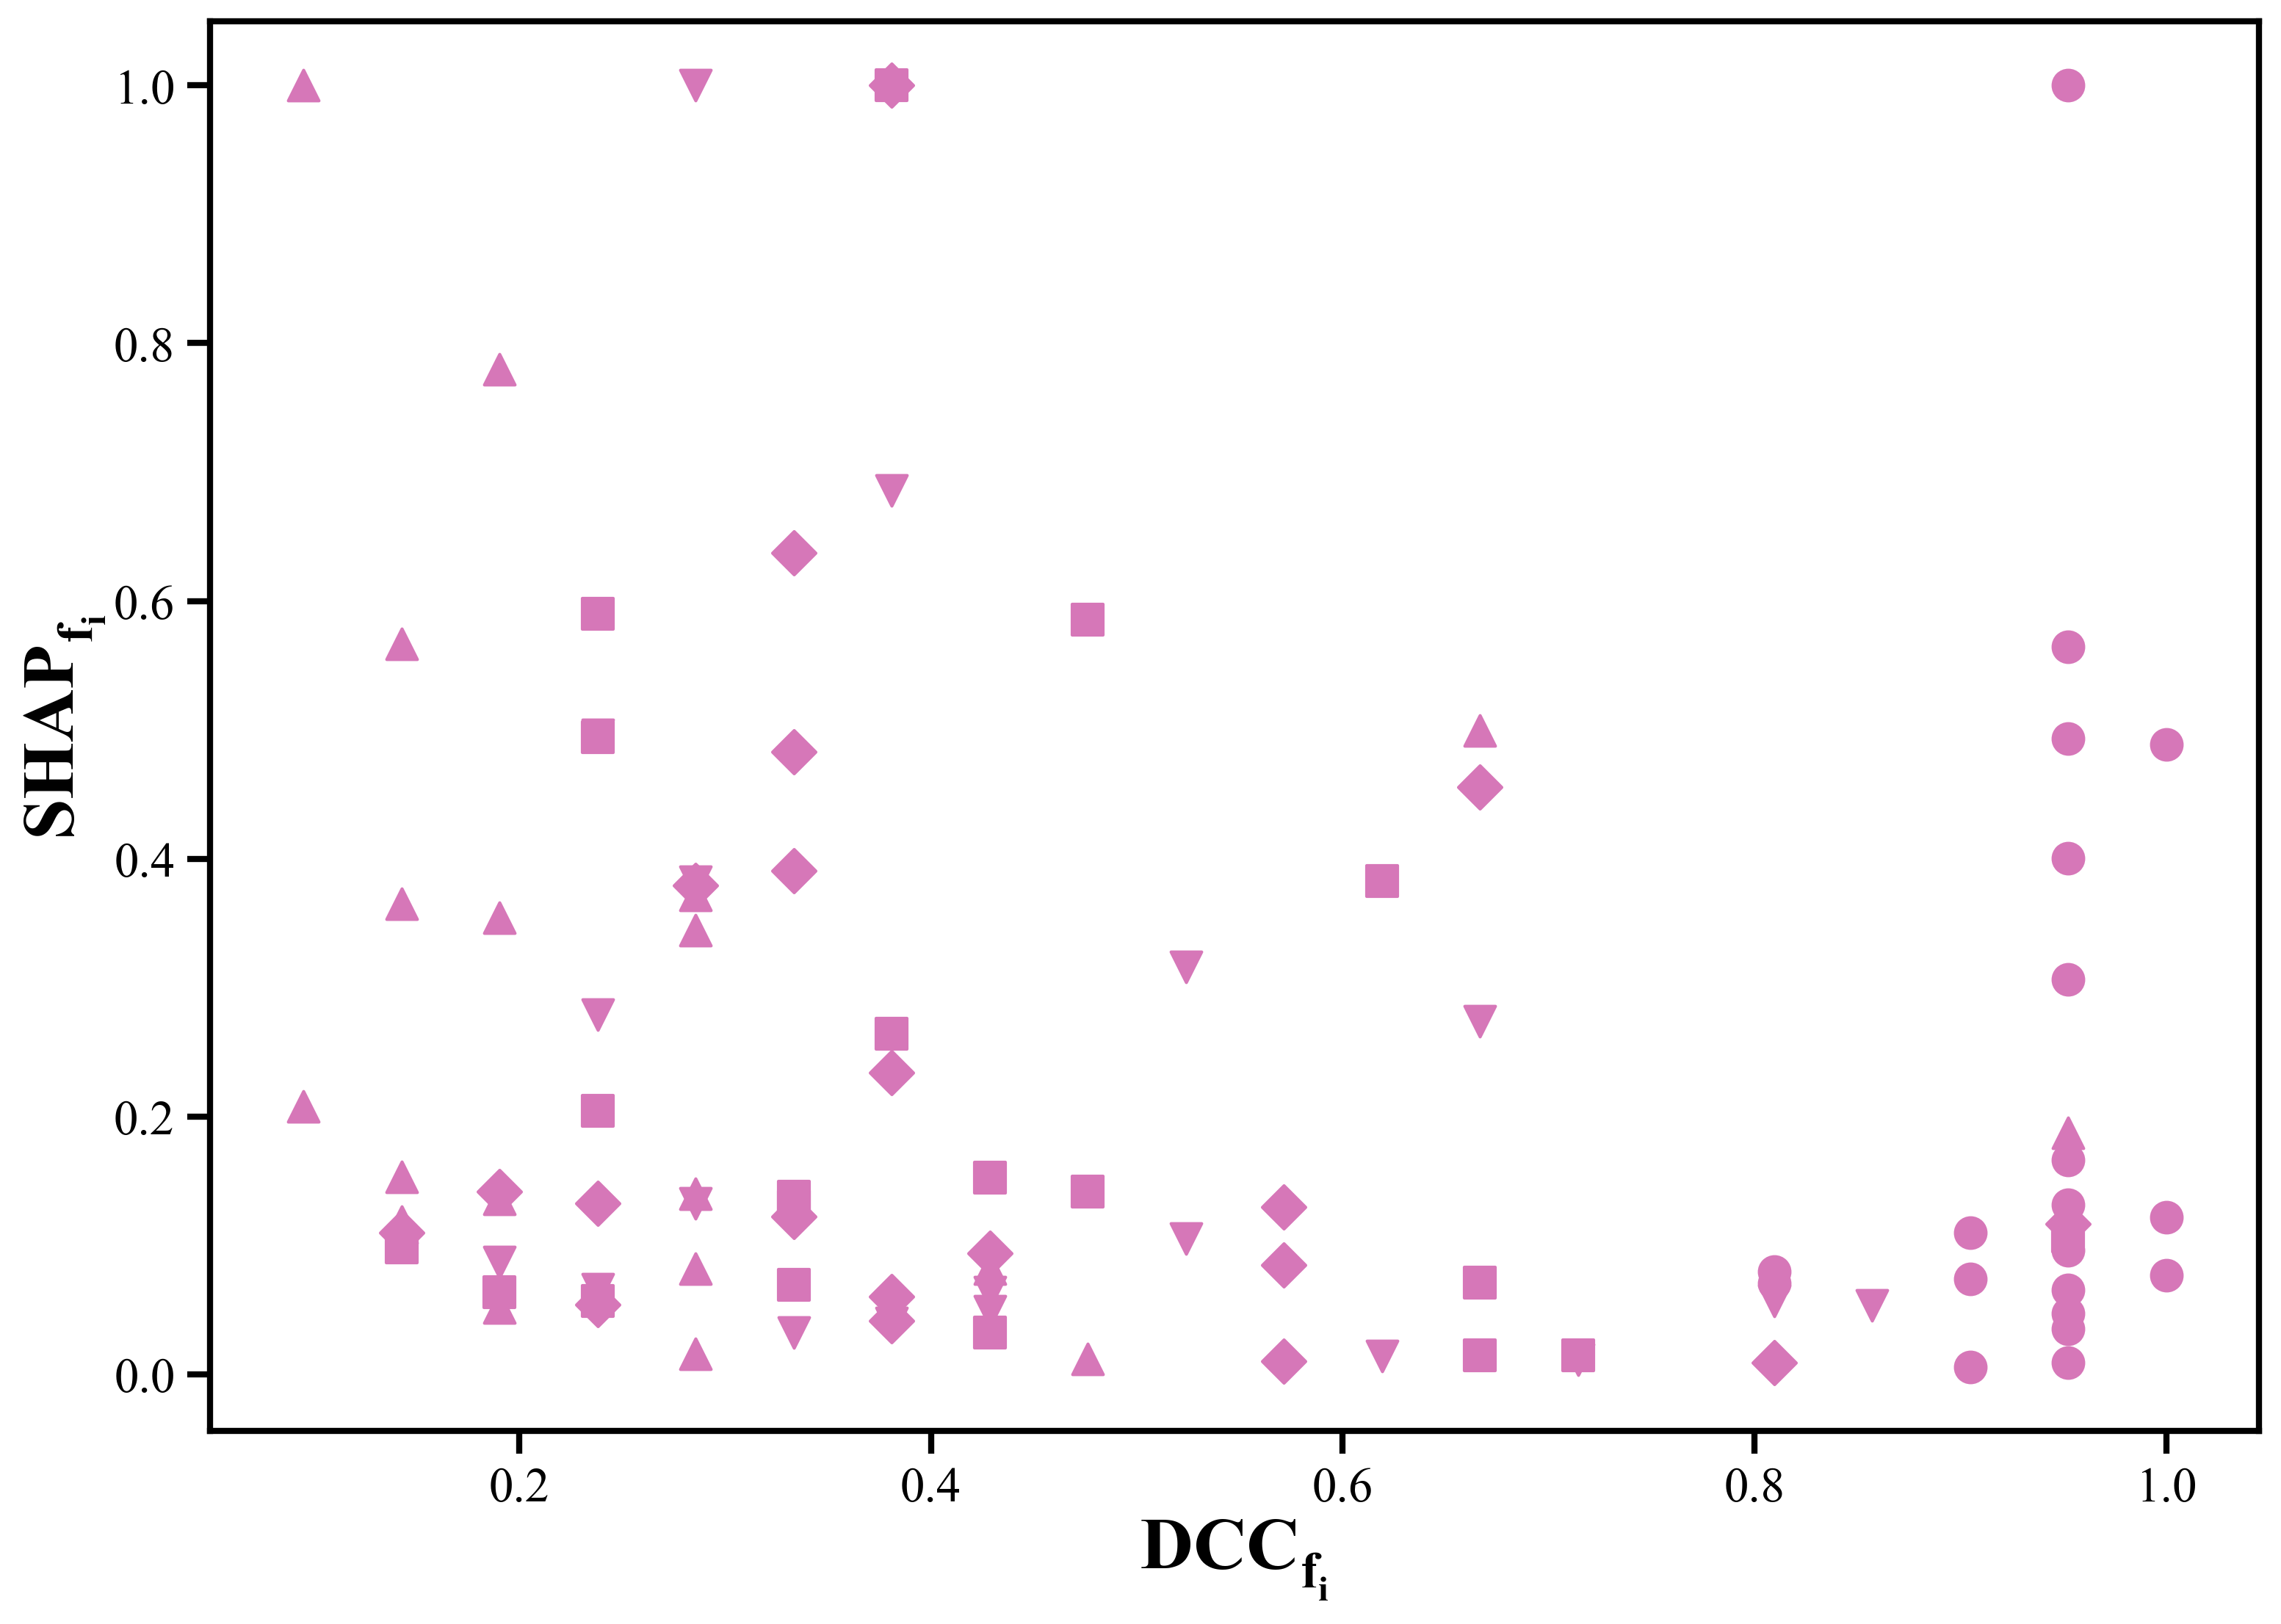

In [13]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


markers = ["o", "s", "D", "v", "^"]
labels = [
    "Deletion",
    r"$Addition_{Linear}$",
    r"$Addition_{Random}$",
    r"$Replacement_{Linear}$",
    r"$Replacement_{Random}$",
]
dataset2colors = {}
colors = ["#ff595e","#1982c4","#6a4c93","#d677b8", "#222222"]
for k in results.keys():
    dataset_name = results[k]["name"]
    task_type = results[k]["type"]
    target_col = results[k]["target_col"]
    if task_type == "regression":
        fig, ax = plt.subplots(figsize=(12, 8))
        color = colors.pop(0)
        dataset2colors[dataset_name] = color
        for ptb_type in PerturbationType:
            if ptb_type.value not in results[k]:
                continue
            dcc_val = results[k][ptb_type.value]["dcc"]
            feats2shap = results[k][ptb_type.value]["feats2shap"]
            feats = list(feats2shap.keys())
            shape_values = [feats2shap[f] for f in feats]
            shape_values = np.array(shape_values)
            shape_values = shape_values / np.max(shape_values)  # Normalize to [0, 1]
            dcc_values = [dcc_val[f] for f in feats]
            plt.scatter(
                dcc_values,
                shape_values,
                marker=markers[list(PerturbationType).index(ptb_type)],
                s=100,
                color=color,
                label=f"{dataset_name}",
            )

        plt.xlabel(r"$DCC_{f_i}$")
        plt.ylabel(r"$SHAP_{f_i}$")